# Practical 09 - Recurrent Neural Networks

**Disclamer**: Some material from the suggested exercises were retrieved and adapted from the following sources:
* [Coursera Sequence Models course by DeepLearningAI](https://www.coursera.org/learn/nlp-sequence-models)
* [Pytorch Tutorial for RNNs](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
* [Pytorch Sentiment Analysis Tutorial](https://github.com/bentrevett/pytorch-sentiment-analysis)

In [1]:
import numpy as np

np.random.seed(1)

## Question 01


Perform a forward propagation for 

$ x^{(1)} = \begin{bmatrix} \begin{pmatrix}
4 \\ 0 \\ 0 \\ 0
\end{pmatrix}, 
 \begin{pmatrix}
0 \\ 8 \\ 2 \\ 0
\end{pmatrix}
\end{bmatrix}
$

With targets:

$ t^{(1)} = \begin{bmatrix} \begin{pmatrix}
1 \\ 0
\end{pmatrix}, 
 \begin{pmatrix}
0 \\ 1
\end{pmatrix}
\end{bmatrix}
$

Initialize all weights and biases to 0.1, using 3 units per hidden layer, initializing the hidden state to all zeros and using η = 1.0.

----

A Recurrent neural network can be seen as the repetition of a single cell. We are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell. 

<img src="forward-net.png" style="width:700px;height:300px;">


**Steps to code the RNN cell**:
1. Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.
2. Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$.
3. Return $a^{\langle t \rangle}$ and $y^{\langle t \rangle}$ 


In [2]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def rnn_cell_forward(xt, a_prev, Wax, Waa, Wya, ba, by):
    """
    Implements a single forward step of the RNN-cell
    
    Arguments:
        xt -- your input data at timestep "t", numpy array of shape (n_x).
        a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a)
        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
        ba --  Bias, numpy array of shape (n_a, 1)
        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
        a_next -- next hidden state, of shape (n_a)
        yt_pred -- prediction at timestep "t", numpy array of shape (n_y)

    """
    # YOUR CODE HERE

    # compute next activation state
    a_next = np.tanh(np.dot(Wax, xt) + np.dot(Waa, a_prev) + ba)

    # compute output of the current cell
    yt_pred = softmax(np.dot(Wya, a_next) + by)

    return a_next, yt_pred

You can see an RNN as the repetition of the cell you've just built. If your input sequence of data is carried over 10 time steps, then you will copy the RNN cell 10 times. Each cell takes as input the hidden state from the previous cell ($a^{\langle t-1 \rangle}$) and the current time-step's input data ($x^{\langle t \rangle}$). It outputs a hidden state ($a^{\langle t \rangle}$) and a prediction ($y^{\langle t \rangle}$) for this time-step.


<img src="rnn_forward.png" style="width:800px;height:300px;">



Now, we are going to code the RNN forward propagation over the sequence

**Steps**:
1. Create a vector of zeros ($a$) that will store all the hidden states computed by the RNN.
2. Initialize the "next" hidden state as $a_0$ (initial hidden state).
3. Start looping over each time step, your incremental index is $t$ :
    - Update the "next" hidden state and the cache by running `rnn_cell_forward`
    - Keep a history of the parameters for the gradient update
    - Store the "next" hidden state in $a$ ($t^{th}$ position) 
    - Store the prediction in y
4. Return $a$, $y$ and history

In [3]:
def rnn_forward(x, a0, Wax, Waa, Wya, ba, by):
    """
    Implement the forward propagation of the recurrent neural network

    Arguments:
        x -- Input data for every time-step, of shape (n_x, m, T_x).
        a0 -- Initial hidden state, of shape (n_a, m)
        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
        ba --  Bias numpy array of shape (n_a, 1)
        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
        a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
        y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
        history -- tuple of values needed for the backward pass, contains (list of caches, x)
    """

    # YOUR CODE HERE
    # TIP: use rnn_cell_forward() inside a for loop

    # Initialize "history" which will contain the list the parameters in each time-step
    history = []

    # Retrieve dimensions from shapes of x and Wy
    n_x, T_x = x.shape
    n_y, n_a = Wya.shape

    # initialize "a" and "y_pred" with zeros
    a = np.zeros((n_a, T_x))
    y_pred = np.zeros((n_y, T_x))

    # Initialize a_next
    a_next = a0

    # loop over all time-steps
    for t in range(T_x):

        # Update next hidden state, compute the prediction
        a_prev = a_next
        a_next, yt_pred = rnn_cell_forward(x[:,t], a_next, Wax, Waa, Wya, ba, by)

        # Store the time-step in the history
        step_parms = (a_next, a_prev, x[:,t], Wax, Waa, Wya, ba, by)
        history.append(step_parms)

        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:, t] = a_next

        # Save the value of the prediction in y
        y_pred[:, t] = yt_pred

    return a, y_pred, history

In [4]:
# Let's run the rnn_forward for a sequence of 10 elements.
inputs = np.array([[4, 0, 0, 0], [0, 8, 2, 0]]).transpose()

# YOUR CODE HERE
# what are the shapes of the weights and biases?
a0 = .1 * np.ones(3)
Waa = .1 * np.ones((3,3))
Wax = .1 * np.ones((3,4))
Wya = .1 * np.ones((2,3))
ba = .1 * np.ones(3)
by = .1 * np.ones(2)

In [5]:
a, y_pred, history = rnn_forward(inputs, a0, Wax, Waa, Wya, ba, by)

print("a = ", a)
print("a.shape = ", a.shape)
print()
print("y_pred =", y_pred)
print("y_pred.shape = ", y_pred.shape)


a =  [[0.48538109 0.84704925]
 [0.48538109 0.84704925]
 [0.48538109 0.84704925]]
a.shape =  (3, 2)

y_pred = [[0.5 0.5]
 [0.5 0.5]]
y_pred.shape =  (2, 2)


## Question 02

Use PyTorch to implement an RNN cell and use it to generate random person names using the file `names.txt` as training examples.

In [6]:
import torch
import torch.nn as nn
from torch import optim


# Vanilla RNN implementation
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh= nn.Tanh()
        self.o2o = nn.Linear(hidden_size, output_size)
        self.initial_hidden = nn.Parameter(
            torch.zeros(1, hidden_size)
        )
        self.softmax = nn.LogSoftmax(dim=1)

    def single_forward(self, input, hidden):
        # YOUR CODE HERE
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.tanh(self.i2h(input_combined))
        output = self.o2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def forward(self, input_line_tensor):
        # YOUR CODE HERE
        outputs = []

        hidden = self.initial_hidden

        for x_t in input_line_tensor:
            output, hidden = self.single_forward(
                x_t, hidden)
            outputs.append(output)

        return outputs


In [7]:
# all letters to work with the Portuguese names from the train file
all_letters = 'abcdefghijklmnopqrstuvxwyzáàãçéêíóõôú'
n_letters = len(all_letters) + 2 # Plus BOS and EOS marker

# One-hot matrix of first to last letters (not including EOS) for input
# Adds a BOS token as the first token
def inputTensor(line):
    tensor = torch.zeros(len(line)+1, 1, n_letters)
    tensor[0][0][-2] = 1  # BOS
    for letter_idx in range(len(line)):
        letter = line[letter_idx]
        tensor[letter_idx+1][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[l_idx]) for l_idx in range(len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes).unsqueeze(-1)

# Read the list of names
with open("names.txt") as file:
    names = [name.lower().strip() for name in file.readlines()]

print(names)

['francisco', 'maria', 'joão', 'leonor', 'afonso', 'matilde', 'tomás', 'carolina', 'duarte', 'alice', 'gabriel', 'benedita', 'santiago', 'beatriz', 'lourenço', 'mariana', 'rodrigo', 'francisca', 'miguel', 'sofia', 'martim', 'margarida', 'vicente', 'laura', 'mateus', 'camila', 'lucas', 'clara', 'guilherme', 'ana', 'salvador', 'inês', 'pedro', 'lara', 'gonçalo', 'madalena', 'dinis', 'diana', 'rafael', 'vitória', 'gustavo', 'constança', 'bernardo', 'eva', 'josé', 'mafalda', 'diogo', 'gabriela', 'manuel', 'bianca', 'tiago', 'valentina', 'vasco', 'joana', 'henrique', 'íris', 'simão', 'sara', 'diego', 'luana', 'antónio', 'ariana', 'david', 'letícia', 'daniel', 'rita', 'leonardo', 'júlia', 'enzo', 'carlota', 'xavier', 'carminho', 'eduardo', 'luísa', 'andré', 'ema', 'luís', 'olívia', 'isaac', 'helena', 'matias', 'yara', 'valentim', 'aurora', 'artur', 'yasmin', 'samuel', 'emma', 'kevin', 'teresa', 'frederico', 'mara', 'filipe', 'catarina', 'matheus', 'caetana', 'lorenzo', 'melissa', 'noah', 'al

In [8]:
from tqdm import tqdm
from random import shuffle, choices

train_data = [ (inputTensor(name),targetTensor(name)) for name in names ]
hidden_size = 128
num_epochs = 1000
criterion = nn.NLLLoss()
learning_rate = 5e-4
model = RNN(n_letters, hidden_size, n_letters)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(model, train_data, num_epochs, optimizer, criterion ):
    all_losses = []

    for epoch in tqdm(range(num_epochs)):

        shuffle(train_data)
        loss_agg = 0

        for input_line_tensor, target_line_tensor in train_data:

            optimizer.zero_grad()

            outputs = model.forward(input_line_tensor)

            loss = torch.stack(
                [ criterion(o_i, t_i) for o_i ,t_i in zip(outputs, target_line_tensor)]
            ).sum()

            loss.backward()
            optimizer.step()

            loss_agg += loss.item()/ input_line_tensor.size(0)

        all_losses.append(loss_agg)

    return all_losses

all_losses = train(
    model=model,
    train_data=train_data,
    num_epochs=num_epochs,
    optimizer=optimizer,
    criterion=criterion)

100%|██████████| 1000/1000 [02:18<00:00,  7.20it/s]


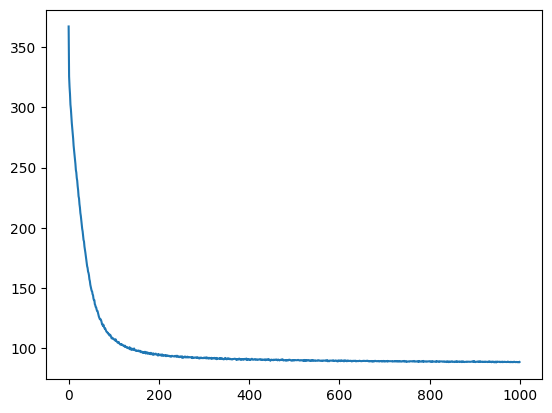

In [9]:
import matplotlib.pyplot as plt

# Let's inpsect the training loss
plt.figure()
plt.plot(all_losses)

In [10]:
# Sample from a category and starting letter
def sampling_names(start_string='', method="sample", kk=1, max_length=20, vocabulary=all_letters):
    with torch.no_grad():  # no need to track history in sampling
        hidden = model.initial_hidden

        # process each letter of start_string, including BOS
        output_name = start_string
        input = inputTensor(start_string)
        if input.shape[0] > 1:
            for input_t in input[:-1].split(1):
                _, hidden = model.single_forward(input_t[0], hidden)

        # start sampling from the last letter of start_string
        for _ in range(max_length):
            output, hidden = model.single_forward(input[-1], hidden)
            # top-k sampling
            if method == "top_k":
                # YOUR CODE HERE
                _, topi = output.topk(kk)
                topi = choices(topi[0])[0]
            # random sampling
            elif method == "sample":
                # YOUR CODE HERE
                topi = torch.multinomial(output.exp(), 1)[0]

            # stop sampling if EOS
            if topi == n_letters - 1:
                break
            # ignore BOS
            elif topi == n_letters - 2:
                continue
            # add letter to output_name
            else:
                letter = vocabulary[topi]
                output_name += letter
            # use the sampled letter as the next input
            input = inputTensor(letter)

        return output_name

starting_string = ''
print("--random sampling--")
# generate 3 random names with random sampling
# note how it is only copying the names from the training set
for _ in range(10):
    print(sampling_names(starting_string, method="sample"))
print("\n--top-k sampling--")
# generate 3 random names with random sampling
for _ in range(10):
    print(sampling_names(starting_string, method="top_k", kk=2))

--random sampling--
letícia
constança
matias

--top-k sampling--
matheledanzozo
miguiss
luasau


## Question 03

In [11]:
!pip install datasets

In [12]:
from datasets import load_dataset_builder
from datasets import load_dataset


ds_builder = load_dataset_builder("imdb")
ds_builder.info.features

Using the latest cached version of the module from /Users/gmc/.cache/huggingface/modules/datasets_modules/datasets/imdb/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0 (last modified on Sun Oct 29 20:25:52 2023) since it couldn't be found locally at imdb., or remotely on the Hugging Face Hub.


{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [13]:
dataset = load_dataset("imdb")


print(f'Number of training examples: {len(dataset["train"])}')
print(f'Number of test examples: {len(dataset["test"])}')

Using the latest cached version of the module from /Users/gmc/.cache/huggingface/modules/datasets_modules/datasets/imdb/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0 (last modified on Sun Oct 29 20:25:52 2023) since it couldn't be found locally at imdb., or remotely on the Hugging Face Hub.
Found cached dataset imdb (/Users/gmc/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 507.44it/s]

Number of training examples: 25000
Number of test examples: 25000


In [27]:
# get a vocabulary of the top K words in the dataset, without stopwords
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def get_vocab(dataset, vocab_size=1024):
    counter = Counter()
    for example in dataset:
        counter.update([word for word in word_tokenize(example['text'].lower())])
    vocab = counter.most_common(vocab_size)
    return [word for word, _ in vocab]

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


In [28]:
# create a pytorch dataset
import torch
from torch.utils.data import Dataset
from collections import defaultdict

class IMDBDataset(Dataset):
    def __init__(self, dataset, vocab, split="train", first_n_words=128):
        self.dataset = dataset
        self.vocab = vocab
        self.unk_idx = 0
        self.pad_idx = 1
        self.first_n_words = first_n_words
        # use a special dict that maps words to indices and if the word is not
        # in the vocab, the special dict automatically returns the index of the
        # unknown token
        self.word2idx = defaultdict(lambda: self.unk_idx)
        self.word2idx['<pad>'] = self.pad_idx
        # add the words to the dict, starting from index 2 (0 is for the unknown token,
        # 1 is for the padding token)
        self.word2idx.update({word: idx + 2 for idx, word in enumerate(self.vocab)})
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        text = word_tokenize(example['text'])
        text = [self.word2idx[word] for word in text][:self.first_n_words]
        return torch.LongTensor(text), example['label']
    
    def collate_fn(self, batch):
        """
        This function takes a list of tokens, already as the index of a vocabulary
        and turns it into a tensor, with padding where appropriate.
        The padding index is stored in self.pad_idx

        Args:
            batch (list): a list of tuples,
                where each tuple has the tokens for one sequence in position 0
                and the label for that sequence in position 1.

        Returns:
            torch.tensor: return the padded tensor and the labels in tensor form.
                The padded tensor is of size [batch_size, max_len],
                the labels tensor is [batch_size]
        """
        # YOUR CODE HERE
        # get the max length of the sentences in the batch
        max_len = max([len(text_tensor) for text_tensor, _ in batch])
        # pad all the sentences to the max length
        padded_tensors = []
        labels = []
        for text_tensor, label in batch:
            # 1 is the index of the padding token
            padded_tensor = torch.ones(max_len, dtype=torch.long) * self.pad_idx
            padded_tensor[:len(text_tensor)] = text_tensor
            padded_tensors.append(padded_tensor)
            labels.append(label)
        # convert the lists to tensors
        padded_tensors = torch.stack(padded_tensors)
        return padded_tensors, torch.LongTensor(labels)


In [29]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.3):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # YOUR CODE HERE

        # pass the tokens through the embedding layer
        emb = self.embedding(text)
        # apply dropout to the embeddings
        emb = self.dropout(emb)

        # pass it simply through the LSTM initialized above
        # (you don't need a for loop, nn.LSTM takes care of that for you)
        enc_output, _ = self.rnn(emb)

        # apply dropout to the output
        enc_output = self.dropout(enc_output)

        # Take the output of the last token of the sequence
        hidden = enc_output[:, -1, :]

        # pass it through the fully connected
        return self.fc(hidden)

In [30]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))

    correct = (rounded_preds == y).float() #convert into float for division 

    acc = correct.sum() / len(correct)
    return acc

In [31]:
from tqdm import tqdm

def train(model, train_daloader, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for text_tensors, targets in tqdm(train_daloader):
        optimizer.zero_grad()

        predictions = model(text_tensors).squeeze(1)

        loss = criterion(predictions, targets.float())

        acc = binary_accuracy(predictions, targets)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_daloader), epoch_acc / len(train_daloader)

In [32]:
def evaluate(model, eval_dataloader, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for text_tensors, targets in tqdm(eval_dataloader):

            predictions = model(text_tensors).squeeze(1)

            loss = criterion(predictions, targets.float())

            acc = binary_accuracy(predictions, targets)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(eval_dataloader), epoch_acc / len(eval_dataloader)

In [33]:
from torch.utils.data import DataLoader
from torch import optim

# set the seed for reproducibility
torch.manual_seed(42)

VOCAB_SIZE = 1024
FIRST_N_WORDS = 128
BATCH_SIZE = 64
INPUT_DIM = VOCAB_SIZE + 2  # +2 for the unknown and padding tokens
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT_RATE = 0.2
LR_RATE = 1e-4

vocab = get_vocab(dataset['train'], vocab_size=1024)
# use 80% of the training set for training and 20% for validation
train_size = int(0.8 * len(dataset['train']))
valid_size = len(dataset['train']) - train_size
# split the training set
train_dataset, valid_dataset = torch.utils.data.random_split(dataset['train'], [train_size, valid_size])
# create the pytorch datasets
train_dataset = IMDBDataset(train_dataset, vocab, split="train", first_n_words=FIRST_N_WORDS)
valid_dataset = IMDBDataset(valid_dataset, vocab, split="valid")
test_dataset = IMDBDataset(dataset['test'], vocab, split="test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=valid_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_dataset.collate_fn)

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            dropout=DROPOUT_RATE)

optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
criterion = nn.BCEWithLogitsLoss()

# Train for 5 epochs
for epoch in range(5):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|██████████| 79/79 [00:16<00:00,  4.83it/s]


Epoch: 01
	Train Loss: 0.692 | Train Acc: 52.03%
	 Val. Loss: 0.689 |  Val. Acc: 54.53%


100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Epoch: 02
	Train Loss: 0.687 | Train Acc: 55.16%
	 Val. Loss: 0.679 |  Val. Acc: 56.96%


100%|██████████| 79/79 [00:16<00:00,  4.80it/s]


Epoch: 03
	Train Loss: 0.688 | Train Acc: 54.76%
	 Val. Loss: 0.685 |  Val. Acc: 58.78%


100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Epoch: 04
	Train Loss: 0.681 | Train Acc: 56.32%
	 Val. Loss: 0.669 |  Val. Acc: 60.15%


100%|██████████| 79/79 [00:16<00:00,  4.78it/s]

Epoch: 05
	Train Loss: 0.663 | Train Acc: 60.83%
	 Val. Loss: 0.660 |  Val. Acc: 61.63%


In [34]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

100%|██████████| 391/391 [01:21<00:00,  4.81it/s]

	 Test Loss: 0.663 |  Test Acc: 61.53%


Let's do some changes to use a bidirectional LSTM and implement some other improvements.

In [35]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bidirectional = bidirectional

        self.rnn = nn.LSTM(embedding_dim,
                            hidden_dim//2 if bidirectional else hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # YOUR CODE HERE

        #text = [batch size, sent len]
        #embedded = [batch size, sent len, emb dim]
        embedded = self.dropout(self.embedding(text))
        embedded = self.dropout(embedded)

        # output = [batch size, sent len, hid dim * num directions]
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        enc_output, (hidden, _) = self.rnn(embedded)

        #hidden = [batch size, hid dim * num directions]
        if self.bidirectional:
            #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        return self.fc(hidden)

In [36]:
VOCAB_SIZE = 1024
FIRST_N_WORDS = 256
BATCH_SIZE = 64
INPUT_DIM = VOCAB_SIZE + 2  # +2 for the unknown and padding tokens
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT_RATE = 0.2
LR_RATE = 1e-4
EMBEDDING_DIM = 128

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT_RATE)

In [37]:
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)

# Train for 5 epochs
for epoch in range(5):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|██████████| 79/79 [00:15<00:00,  5.23it/s]


Epoch: 01
	Train Loss: 0.692 | Train Acc: 51.88%
	 Val. Loss: 0.687 |  Val. Acc: 55.46%


100%|██████████| 79/79 [00:15<00:00,  5.20it/s]


Epoch: 02
	Train Loss: 0.687 | Train Acc: 54.96%
	 Val. Loss: 0.682 |  Val. Acc: 56.41%


100%|██████████| 79/79 [00:15<00:00,  5.16it/s]


Epoch: 03
	Train Loss: 0.677 | Train Acc: 57.29%
	 Val. Loss: 0.665 |  Val. Acc: 60.09%


100%|██████████| 79/79 [00:15<00:00,  5.12it/s]


Epoch: 04
	Train Loss: 0.658 | Train Acc: 61.00%
	 Val. Loss: 0.722 |  Val. Acc: 60.78%


100%|██████████| 79/79 [00:15<00:00,  5.02it/s]

Epoch: 05
	Train Loss: 0.628 | Train Acc: 65.24%
	 Val. Loss: 0.667 |  Val. Acc: 65.61%


In [38]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

100%|██████████| 391/391 [01:16<00:00,  5.13it/s]

	 Test Loss: 0.659 |  Test Acc: 65.82%
